# A Tour of Optimizers in PyTorch

Have you ever found yourself using optimizers such as `Adam` and `RMSprop` without actually knowing how they worked? Me too.

Together, we're going to walk through some optimization algorithms, giving some intuition on how they work and then implementing each one in PyTorch.

Before we start to walk down this path, one quick clarification on something that gets lost in the weeds sometimes - **backpropagation** is the algorithm which computes the gradient of the parameters within a neural network with respect to the loss, whereas **optimization** algorithms take that per parameter gradient and use it to figure out how it should update the parameters to reduce the loss. 

Another quick note: these implementations are more for educational purposes and when actually training a neural network then you should definitely use the proper PyTorch optimizers provided in `torch.optim`. I've done by best to ensure these implementations are correct, but I've leaned towards readability over efficiency.

Finally, I make no claim there is a "best" optimizier, because there isn't one. A recent [paper](https://arxiv.org/abs/2007.01547) has shown that there is no optimizer that is consistenly better than all of the others across all problems. The optimizers shown to do better here are doing so on a single problem - classification of MNIST digits using an MLP with a single hidden layer - and I make no attempt to do a fair grid search across different learning rates and optimizer hyperparameters. Some optimizers we'll just fire off with the default values and some we'll try a few different hyperparamers just to see what happens. We also don't look into using any learning rate schedulers and we only run our experiments with a single random seed.

With that being said, if in doubt, using `Adam` with the default hyperparameters is usually a good starting point.

Now, let's begin by importing some libraries we'll be using.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tqdm

We'll also set the random seed so hopefully these results can be replicated.

In [2]:
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

The dataset we are going to use is the infamous MNIST dataset - hand drawn digits from 0-9 that consist 28x28 black and white images.

We'll normalize the images using a pre-computed mean and standard deviation and perform some data augmentation, namely: randomly rotating and cropping the images.

Note that we only get the training data as we only care about how well these optimizers minimize loss and not how well the architecture generalizes. In practice lower training loss doesn't necessarily imply better validation/test loss due to overfitting.

In [3]:
mean = 0.13066048920154572
std = 0.30810779333114624

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.RandomCrop(28, padding = 2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])])

train_data = datasets.MNIST(root = '.data', 
                            train = True, 
                            download = True, 
                            transform = train_transforms)

We then create the iterator for the data. 

The batch size is chosen arbitrarily and your results may differ if using a different batch size. Note that in practice a larger batch size usually allows you to use a larger learning rate.

In [4]:
batch_size = 128

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = batch_size)

Next, we'll define our architecture: a multi-layer perceptron (MLP) with a single hidden layer. 

The `init_params` function can be called to initialize the values following the "Kaiming" (also known as "He") initialization scheme because this usually does a good job when using the ReLU activation function. The biases are initialized to zeros which is pretty common.

Your initialization scheme will also change the results of your optimizers but I believe the one we're using here is sensible.

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hid_dim)
        self.layer2 = nn.Linear(hid_dim, hid_dim)
        self.layer3 = nn.Linear(hid_dim, output_dim)
        self.init_params()

    def init_params(self):
        for n, p in self.named_parameters():
            if 'weight' in n:
                nn.init.kaiming_normal_(p, nonlinearity='relu')
            elif 'bias' in n:
                nn.init.constant_(p, 0)

    def forward(self, x):
        # x = [batch size, channels, height, width]
        batch_size, *_ = x.shape
        x = x.view(batch_size, -1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

Our model uses a 256-dimensional hidden layer, again this is chosen pretty much arbitrarily and smaller values may work just as well.

In [6]:
input_dim = 28 * 28
hid_dim = 256
output_dim = 10

model = MLP(input_dim, hid_dim, output_dim)

Supervised learning where each example belongs to a single class almost always cross-entropy loss.

In [7]:
criterion = nn.CrossEntropyLoss()

We'll then put the model and the loss function on to our GPU, if we have one.

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

Next up, we'll define some functions for training the model with our optimizers and plotting the results.

`train_epoch` performs a single epoch of training and returns a list of losses per batch.

In [9]:
def train_epoch(iterator, model, optimizer, criterion, device):
    """Performs one epoch of training."""
    
    losses = []

    for images, labels in tqdm.tqdm(iterator):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return losses

`train` initializes a model and then performs `n_epochs` of training, storing and returning the loss per batch over all of the epochs.

In [10]:
def train(train_iterator, model, optimizer, criterion, device, n_epochs=5):
    """Trains the model for the given amount of epochs."""
    
    losses = []

    model.init_params()

    for epoch in range(n_epochs):
        epoch_losses = train_epoch(train_iterator, model, optimizer, criterion, device)
        losses.extend(epoch_losses)

    return losses

Finally, we have two functions.

`plot_loss` is used for plotting the results of a single experiment, whereas `plot_losses` plots the results of multiple experiments - used to compare optimizers against each other.

In [11]:
def plot_loss(loss, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the loss from a single experiment."""
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(loss)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()

In [12]:
def plot_losses(losses, labels, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the losses from multiple experiments."""
    
    fig, ax = plt.subplots(figsize=figsize)
    for loss, label in zip(losses, labels):
        ax.plot(loss, label=label)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()
    ax.legend(loc='upper right')

Now let's implement our first optimizer!

## Optimizer 1: Stochastic Gradient Descent (SGD)

Stochastic gradient descent is the simplest optimization algorithm, so it's a good place to start. We take our current model parameters $\theta_t$ and subtract the gradient of those parameters, $\nabla_\theta J(\theta_t)$, multiplied by the "learning rate", $\eta$. 

We can think of the learning rate as a parameter that controls the magnitude of the parameter update. If our learning rate is too small then our parameter updates will also be too small for us to train our model in a reasonable amount of time. If our learning rate is too large then the size of the parameter updates will be so large than learning will become unstable! If you ever get a `nan` value for your loss then one thing to check would be to use a lower learning rate.

The SGD algorithm is given as:

$$\theta_{t+1} = \theta_t - \eta \cdot \nabla_\theta J(\theta_t)$$

However, we don't just have one set of parameters, $\theta$, we have multiple parameters because we have the weights of layer 1, the biases of layer 1, the weights of layer 2, the biases of layer 2, etc. So we'll subscript the parameters with $i$:

$$\theta_{t+1,i} = \theta_{t,i} - \eta \cdot \nabla_\theta J(\theta_{t,i})$$

We subtract because we want to descend the gradient and move towards a lower loss value. Addition would ascend the gradient, hence it's called gradient ascent.

One final thing to mention is the difference gradient descent, stochastic gradient descent, mini-batch gradient descent and on-line gradient descent. **Gradient descent** means we calculate the gradient using every single example in our training set and then do a single parameter update. This is relatively slow as in our experiments it means only updating the parameters after seeing all 60,000 examples. The other extreme is **stochastic gradient descent** which means we update our parameters after every single example. This is usually very noisy, so a happy medium is updating the parameters after we have seen a *batch* of examples - **mini-batch gradient descent**. Last up is **online gradient descent** which usually implies our model is in production and is being constantly fed new examples on which it is using to update its parameters.

Confusingly, **gradient descent** is also sometimes called **batch gradient descent**, where the whole dataset counts as one giant batch, hence why using sampled batch of examples is called a *mini-batch*. 

In PyTorch, the optimizer is called stochastic gradient descent even though it can do any of the above gradient descent variants, and the general rule of thumb is that nowadays when someone mentions stochastic gradient descent then they mean mini-batch gradient descent.

Anyway, on to the implementation. All optimizers need a way of keeping track of the parameters they're supposed to be updating `model_params` and a learning rate, `lr`. SGD in PyTorch doesn't have a default learning rate but `1e-3` is a common default learning rate value for other optimizers, so we use it here. All optimizers need a `zero_grad` function in order to remove the gradients calculated from the last update step, and a `step` function to perform a parameter update. 

Note that any PyTorch method with a trailing underscore, e.g. `.sub_`, means the operation is in-place, hence below our `step` function is updating each `param`, a tensor of parameters, in-place. These in-place operations are usually significantly faster non in-place operations.

In [13]:
class SGD:
    def __init__(self, model_params, lr=1e-3):
        self.model_params = list(model_params)
        self.lr = lr

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param in self.model_params:
            param.sub_(self.lr * param.grad)

We can define our optimizer like so:

In [14]:
optimizer = SGD(model.parameters())

Then we use it to train our model for five epochs and get the training loss.

In [15]:
sgd_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 49.26it/s]


Now let's plot it and see what it looks like.

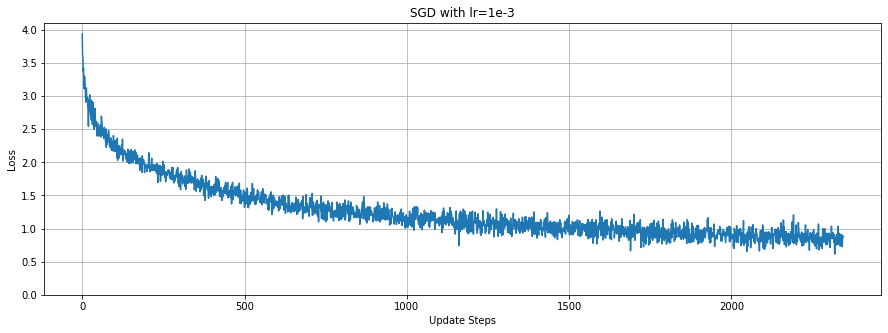

In [16]:
plot_loss(sgd_loss, 'SGD with lr=1e-3')

Looks reasonable, the loss starts at a high value as our parameters are randomly initialized and then proceeds to decrease steadily. We can't really tell how "good" it is without comparing it against another optimizer, so let's go ahead and do that now.

## Optimizer 2: SGD with Momentum

One way to think of SGD is that it's a ball rolling down a hill where areas of high gradient are steep parts of the hill and areas of low gradient are very flat areas. Sometimes the global minima - the point with the lowest loss - is in the middle of a giant flat area. The problem is that because these flat areas have small gradients they also give small update steps which makes learning slow. 

What if we expanded on the "ball rolling down a hill" analogy and tried to add something to our optimizer that made it keep the "momentum" gained rolling down the steep hills whilst it's going across the flat areas? 

Well hey, that's exact what SGD with momentum does! Our parameter update is now calculated using a velocity, $v$, which depends on the current gradient multiplied by the learning rate plus the previous velocity multipled by the momentum $\gamma$. 

\begin{align*}
    v_{t,i} &= \gamma \cdot v_{t-1,i} + \eta \cdot \nabla_\theta J(\theta_{t,i})\\
    \theta_{t+1,i} &= \theta_{t,i} - v_{t,i}\\
\end{align*}

If momentum is zero then we don't care about the previous velocity at all and this algorithm becomes SGD. Commonly used momentum values are usually around 0.9ish.

PyTorch optimizers are sometimes a little different than the actual algorithms. PyTorch's version of SGD with momentum moves the learning rate outside of the equation for velocity:

\begin{align*}
    v_{t,i} &= \gamma \cdot v_{t-1,i} + \nabla_\theta J(\theta_{t,i})\\
    \theta_{t+1,i} &= \theta_{t,i} - \eta \cdot v_{t,i}\\
\end{align*}

If the PyTorch implementation differs then we'll implement the PyTorch version as we use it as a reference.

Note that the velocity `v` is a list of tensors corresponding to the model parameters so we are storing the velocity of every single parameter in our model.

In [17]:
class SGDMomentum:
    def __init__(self, model_params, lr=1e-3, momentum=0.9):
        self.model_params = list(model_params)
        self.lr = lr
        self.momentum = momentum
        self.v = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, v in zip(self.model_params, self.v):
            v.mul_(self.momentum).add_(param.grad)
            param.sub_(self.lr * v)

Now let's define our optimizer, train our model and plot the results.

In [18]:
optimizer = SGDMomentum(model.parameters())

In [19]:
sgd_momentum_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 49.24it/s]


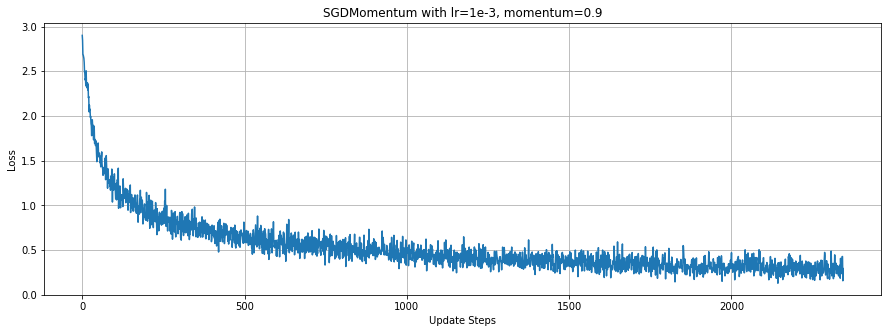

In [20]:
plot_loss(sgd_momentum_loss, 'SGDMomentum with lr=1e-3, momentum=0.9')

Now let's compare SGD and SGD with momentum.

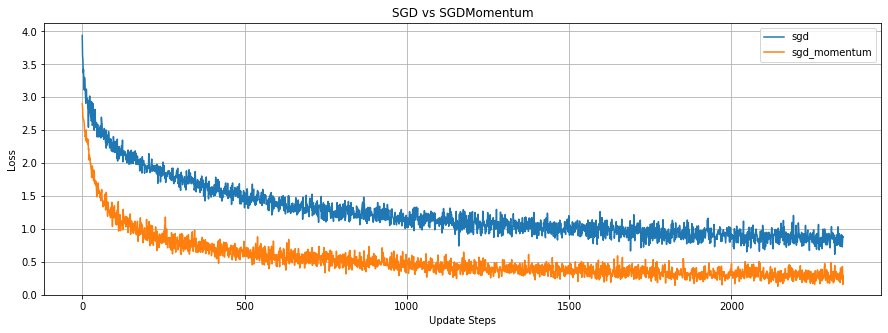

In [21]:
losses = [sgd_loss, sgd_momentum_loss]
labels = ['sgd', 'sgd_momentum']

plot_losses(losses, labels, 'SGD vs SGDMomentum')

As we can see, not only does momentum help us reach the lowest SGD loss - around 1.0 - in a fraction of the time it also gives us a lower overall!

There's also another variant of SGD with momentum called **Nesterov Accelerated Gradient** (NAG) but we aren't going to implement it here for a few reasons:

1. There are multiple different ways to implement it, see [this](https://jlmelville.github.io/mize/nesterov.html) excellent article for details on the variations, and PyTorch implements it in a completely different way
2. I have personally found that it has never provided a noticable improvement over regular momentum
3. It's not very commonly used

Let's move on to the next optimizer.

## Optimizer 3: Adagrad

One downside with SGD is that we use a single learning rate across all of our parameters, and that this learning rate is fixed through the entirety of training.

Ideally, parameters that are updated more frequently have a lower learning rate and parameters that are updated infrequently have a larger learning rate.

This is what Adagrad does. We use $G_{i,t}$ which is the sum of the squared gradients for parameter $i$ up to, and including, time-step $t$. $G_{i,t}$ is initialized to some value, usually zero by default.

$$\theta_{t+1,i} = \theta_{t,i} - \frac{\eta}{\sqrt{G_{t,i}}+\epsilon} \cdot \nabla_\theta J(\theta_{t,i})$$

where:

$$G_{t,i} = G_{t-1,i} + \Big(\nabla_\theta J(\theta_{t,i})\Big)^2$$

$\epsilon$ is very small number, used to avoid division by zero in the denominato. Sometimes you'll see $\epsilon$ inside the square root and sometimes it will be outside. PyTorch leaves it outside so we will too.

We implement Adagrad below, initializing $G$ as a list of tensors called `acc_sqr_grads` and using `std` to refer to the denominator of the update step equation. 

In [27]:
class Adagrad:
    def __init__(self, model_params, lr=1e-2, init_acc_sqr_grad=0, eps=1e-10):
        self.model_params = list(model_params)
        self.lr = lr
        self.acc_sqr_grads = [torch.full_like(p, init_acc_sqr_grad) for p in self.model_params]
        self.eps = eps

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, acc_sqr_grad in zip(self.model_params, self.acc_sqr_grads):
            acc_sqr_grad.add_(param.grad * param.grad)
            std = acc_sqr_grad.sqrt().add(self.eps)
            param.sub_((self.lr / std) * param.grad)

In [28]:
optimizer = Adagrad(model.parameters())

In [29]:
adagrad_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 48.55it/s]


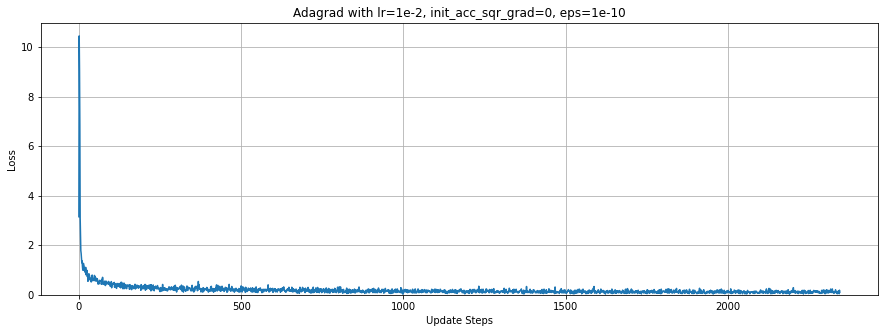

In [30]:
plot_loss(adagrad_loss, 'Adagrad with lr=1e-2, init_acc_sqr_grad=0, eps=1e-10')

Large spike is due to initial $G$ being very small and thus the learning rate is divided by a very small number, making it very large. 

Large learning usually give higher losses.

Let's trim the start to get a better view what the final loss value is.

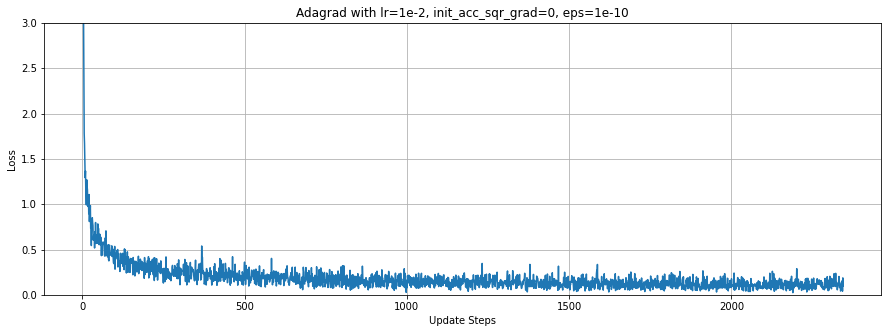

In [31]:
plot_loss(adagrad_loss, 'Adagrad with lr=1e-2, init_acc_sqr_grad=0, eps=1e-10', ymax=3.0)

In [ ]:
losses = [sgd_loss, sgd_momentum_loss, adagrad_loss]
labels = ['sgd', 'sgd_momentum', 'adagrad_loss']

plot_losses(losses, labels, 'SGD vs. SGDMomentum vs. Adagrad')

We don't really mind the large spike at the start as long as the final loss is good, but let's try some different initial values for $G$ and store them all in a `adagrad_losses` dictionary with the key being the initial $G$ value and the values being a list of training loss per batch.

In [32]:
adagrad_losses = {0: adagrad_loss}

In [33]:
optimizer = Adagrad(model.parameters(), init_acc_sqr_grad=1.0)

In [34]:
adagrad_losses[1.0] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 47.76it/s]


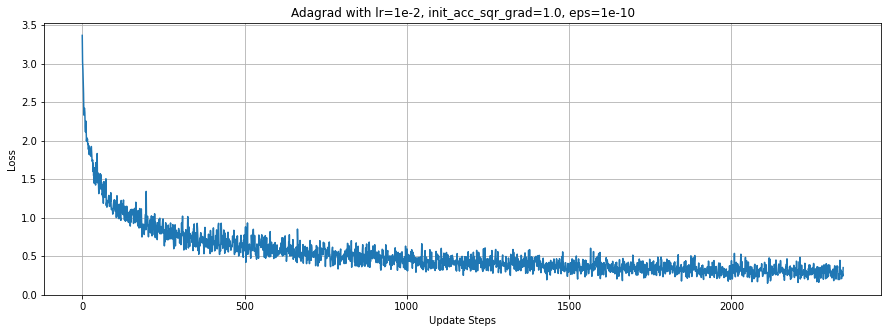

In [35]:
plot_loss(adagrad_losses[1.0], 'Adagrad with lr=1e-2, init_acc_sqr_grad=1.0, eps=1e-10')

In [36]:
optimizer = Adagrad(model.parameters(), init_acc_sqr_grad=0.1)

In [37]:
adagrad_losses[0.1] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 48.96it/s]


In [38]:
optimizer = Adagrad(model.parameters(), init_acc_sqr_grad=0.01)

In [39]:
adagrad_losses[0.01] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 47.87it/s]


In [40]:
optimizer = Adagrad(model.parameters(), init_acc_sqr_grad=0.001)

In [41]:
adagrad_losses[0.001] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 50.19it/s]


Now let's compare all of our four values for the initial $G$ value.

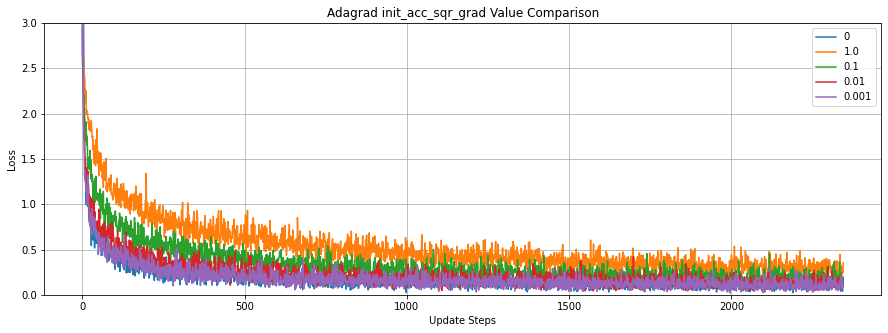

In [42]:
labels, losses = zip(*adagrad_losses.items())

plot_losses(losses, labels, 'Adagrad init_acc_sqr_grad Value Comparison', ymax=3.0)

As we can see, very small non-zero initial values of $G$ give us almost the same loss curve as $G$ initialized to zero, but without the large spike in loss at the beginning of training. Note: we could also get similar results by increasing $\epsilon$.

The graph also highlights the downside of Adagrad: as $G$ is monotonically increasing, it will be dividing the learning rate by a larger number each time. This causes the size of the steps taken to reduce every update step. As the results for an initial $G$ value of 1.0 show, we can see that these smaller step sizes actually increase the time taken for the model to converge, and in extreme causes will cause the step sizes to approach zero meaning the parameters will stop updating completely. In practice, we do want the learning rate to decrease whilst training, but ideally would not want it to become zero. 

Let's compare Adagrad against the SGD optimizers.

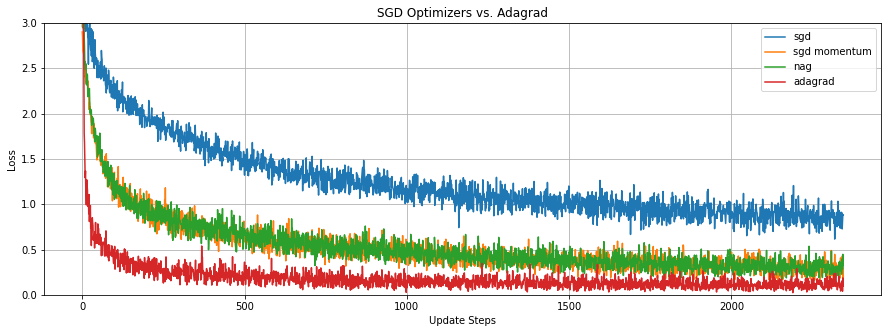

In [43]:
losses = [sgd_loss, sgd_momentum_loss, adagrad_loss]
labels = ['sgd', 'sgd momentum', 'adagrad']

plot_losses(losses, labels, 'SGD Optimizers vs. Adagrad', ymax=3.0)

## Optimizer 4: Adadelta

All of our update step equations can be written in the form of:

$$\theta_{t+1,i} = \theta_{t,i} + \Delta \theta_{t,i}$$

where $\Delta \theta_{t,i}$ is the size of the parameter update, i.e. in SGD we had: 

$$\Delta \theta_{t,i} = - \eta \cdot \nabla_\theta J(\theta_{t,i})$$

and in Adagrad we had: 

$$\Delta \theta_{t,i} = - \frac{\eta}{\sqrt{G_{t,i}}+\epsilon} \cdot \nabla_\theta J(\theta_{t,i}))$$

For Adadelta, to solve the problem of $G$ monotonically increasing we first replace $G_{t,i}$ with $E[g^2]_{t,i}$, an exponential moving average of the square of the gradients so far.

$$E[g^2]_{t,i} = \rho E[g^2]_{t-1,i} + (1-\rho)g^2_{t,i}$$

where $g_{t,i} = \nabla_\theta J(\theta_{t,i})$ - which we've done just to simplify the notation a little bit - and $\rho$ controls how much we care about the previous gradients in the exponential moving average, $\rho=0$ means we don't care about them at all.

Thus, we get an update step equation of:

$$\Delta \theta_t = - \frac{\eta}{\sqrt{E[g^2]_{t,i} + \epsilon}} \cdot g_{t,i}$$

Notice that the $\epsilon$ term has now moved inside the square root. The problem with above equation - and in fact all update equations seen so far - is the units of the update do not match the units of the parameters. To solve this they use a second exponential moving average, but this one is of the parameter updates.

To get the final Adadelta equation, we take our first attempt, but replace $\eta$ with an exponential moving average of the squared parameter updates:

$$E[\Delta \theta^2]_{t-1,i} = \rho E[\Delta \theta^2]_{t-2,i} + (1-\rho)\Delta \theta^2_{t-1,i}$$

Thus we get:

$$\Delta \theta_{t,i} = - \frac{\sqrt{E[\Delta \theta^2]_{t-1,i} + \epsilon}}{\sqrt{E[g^2]_{t,i}+\epsilon}} \cdot g_{t,i}$$

This means that we do not even need to use a learning rate value, however in the PyTorch implementation they do use one (which defaults to 1.0), so they end up with:

$$\Delta \theta_{t,i} = - \eta \cdot \frac{\sqrt{E[\Delta \theta^2]_{t-1,i} + \epsilon}}{\sqrt{E[g^2]_{t,i}+\epsilon}} \cdot g_{t,i}$$

Their default `eps` value also changes from `1e-10` to `1e-6`.

In [44]:
class Adadelta:
    def __init__(self, model_params, lr=1.0, rho=0.9, eps=1e-6):
        self.model_params = list(model_params)
        self.lr = lr
        self.rho = rho
        self.eps = eps
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        self.avg_sqr_deltas = [torch.zeros_like(p) for p in self.model_params] 

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad, avg_sqr_delta in zip(self.model_params, \
                                                      self.avg_sqr_grads, \
                                                      self.avg_sqr_deltas):
            avg_sqr_grad.mul_(self.rho).add_(param.grad * param.grad * (1 - self.rho))
            std = avg_sqr_grad.add(self.eps).sqrt()
            delta = avg_sqr_delta.add(self.eps).sqrt().div(std).mul(param.grad)
            param.sub_(self.lr * delta)
            avg_sqr_delta.mul_(self.rho).add_(delta * delta * (1 - self.rho))

In [45]:
optimizer = Adadelta(model.parameters())

In [46]:
adadelta_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:10<00:00, 45.96it/s]


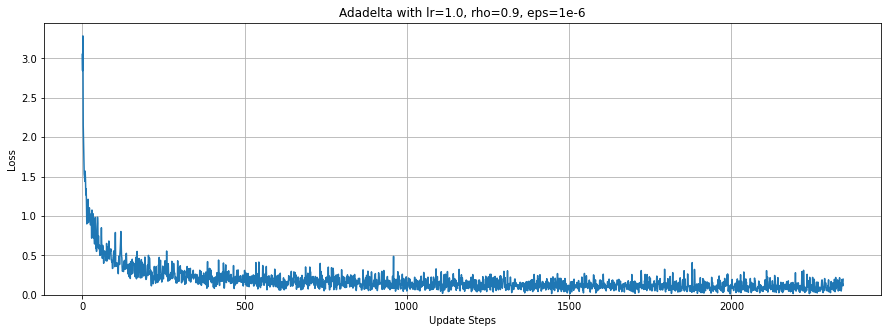

In [47]:
plot_loss(adadelta_loss, 'Adadelta with lr=1.0, rho=0.9, eps=1e-6')

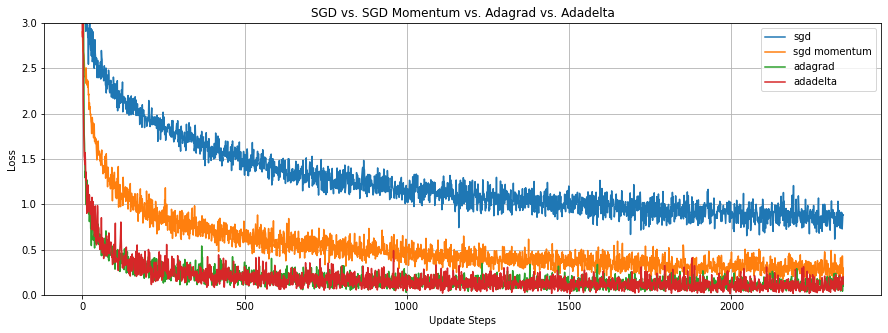

In [48]:
losses = [sgd_loss, sgd_momentum_loss, adagrad_loss, adadelta_loss]
labels = ['sgd', 'sgd momentum', 'adagrad', 'adadelta']

plot_losses(losses, labels, 'SGD vs. SGD Momentum vs. Adagrad vs. Adadelta', ymax=3.0)

## Optimizer 5: RMSprop

Remember that "first attempt" at the Adadelta equation? The one that we said had the issue of the update units not matching the parameter units? 

Well, that's RMSprop!

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{E[g^2]_{t,i} + \epsilon}} \cdot g_{t,i}$$

In PyTorch, they move the $\epsilon$ term outside of the square root for some reason, which gives us:

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{E[g^2]_{t,i}} + \epsilon} \cdot g_{t,i}$$

In the implementation they also change the default `lr` to `1e-2`, they rename `rho` to `alpha` and give it a default value of `0.99`, and also change the default `eps` to `1e-8`.

In [49]:
class RMSprop:
    def __init__(self, model_params, lr=1e-2, alpha=0.99, eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad in zip(self.model_params, self.avg_sqr_grads):
            avg_sqr_grad.mul_(self.alpha).add_(param.grad * param.grad * (1 - self.alpha))
            std = avg_sqr_grad.sqrt().add(self.eps)
            param.sub_((self.lr / std) * param.grad)

In [50]:
optimizer = RMSprop(model.parameters())

In [51]:
rmsprop_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 50.68it/s]


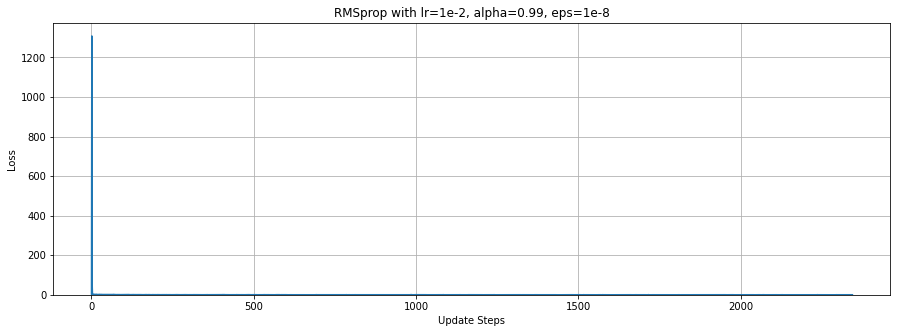

In [52]:
plot_loss(rmsprop_loss, 'RMSprop with lr=1e-2, alpha=0.99, eps=1e-8')

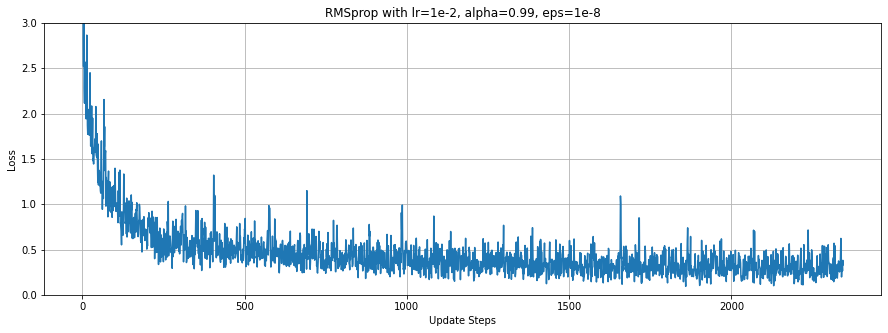

In [53]:
plot_loss(rmsprop_loss, 'RMSprop with lr=1e-2, alpha=0.99, eps=1e-8', ymax=3.0)

In [54]:
class RMSpropAlt:
    def __init__(self, model_params, lr=1e-2, alpha=0.99, eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad in zip(self.model_params, self.avg_sqr_grads):
            avg_sqr_grad.mul_(self.alpha).add_(param.grad * param.grad * (1 - self.alpha))
            std = avg_sqr_grad.add(self.eps).sqrt()
            param.sub_((self.lr / std) * param.grad)

In [55]:
optimizer = RMSpropAlt(model.parameters())
rmspropalt_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 49.69it/s]


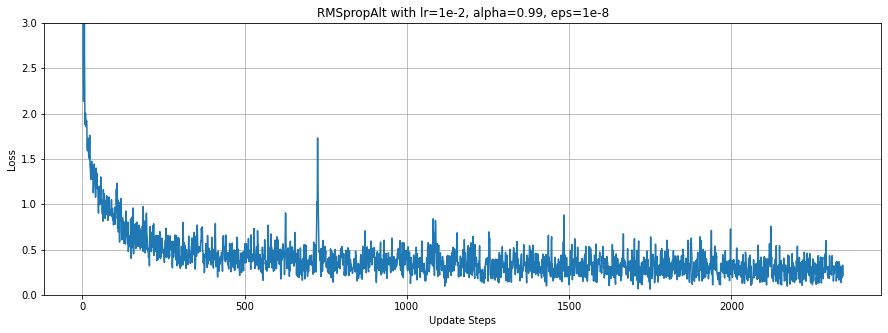

In [56]:
plot_loss(rmspropalt_loss, 'RMSpropAlt with lr=1e-2, alpha=0.99, eps=1e-8', ymax=3.0)

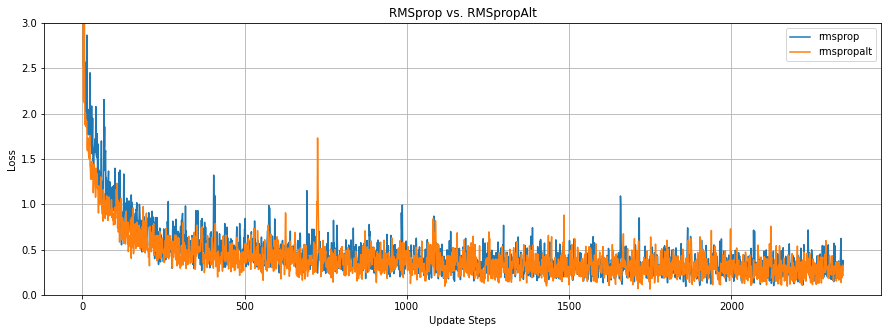

In [57]:
losses = [rmsprop_loss, rmspropalt_loss]
labels = ['rmsprop', 'rmspropalt']

plot_losses(losses, labels, 'RMSprop vs. RMSpropAlt', ymax=3.0)

In [ ]:
http://zna.do/epsilon

In [58]:
rmsprop_losses = {1e-8: rmsprop_loss}

In [59]:
optimizer = RMSprop(model.parameters(), eps=1e-6)

In [60]:
rmsprop_losses[1e-6] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 49.64it/s]


In [61]:
optimizer = RMSprop(model.parameters(), eps=1e-4)

In [62]:
rmsprop_losses[1e-4] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 50.95it/s]


In [63]:
optimizer = RMSprop(model.parameters(), eps=1e-2)

In [64]:
rmsprop_losses[1e-2] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 50.78it/s]


In [65]:
optimizer = RMSprop(model.parameters(), eps=1)

In [66]:
rmsprop_losses[1] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 50.91it/s]


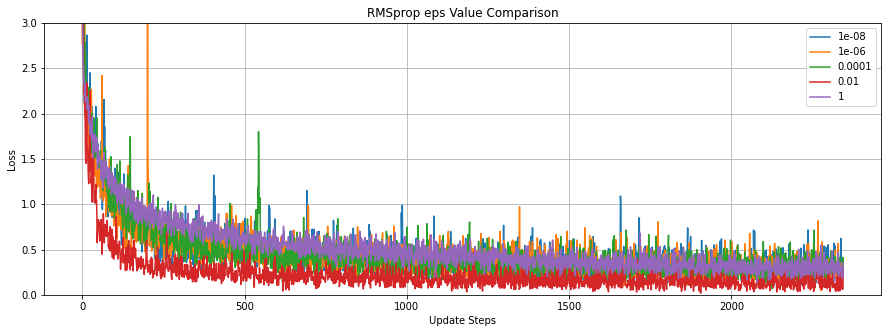

In [67]:
labels, losses = zip(*rmsprop_losses.items())

plot_losses(losses, labels, 'RMSprop eps Value Comparison', ymax=3.0)

In [68]:
rmspropalt_losses = {1e-8: rmspropalt_loss}

In [69]:
optimizer = RMSpropAlt(model.parameters(), eps=1e-6)

In [70]:
rmspropalt_losses[1e-6] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 50.59it/s]


In [71]:
optimizer = RMSpropAlt(model.parameters(), eps=1e-4)

In [72]:
rmspropalt_losses[1e-4] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 47.45it/s]


In [73]:
optimizer = RMSpropAlt(model.parameters(), eps=1e-2)

In [74]:
rmspropalt_losses[1e-2] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 48.16it/s]


In [75]:
optimizer = RMSpropAlt(model.parameters(), eps=1)

In [76]:
rmspropalt_losses[1] = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:09<00:00, 48.81it/s]


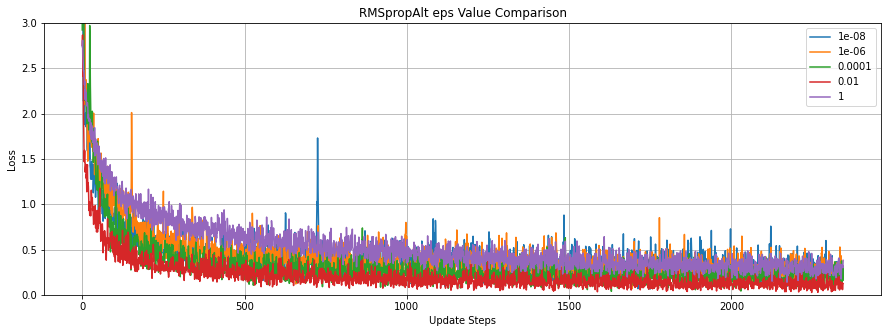

In [77]:
labels, losses = zip(*rmspropalt_losses.items())

plot_losses(losses, labels, 'RMSpropAlt eps Value Comparison', ymax=3.0)

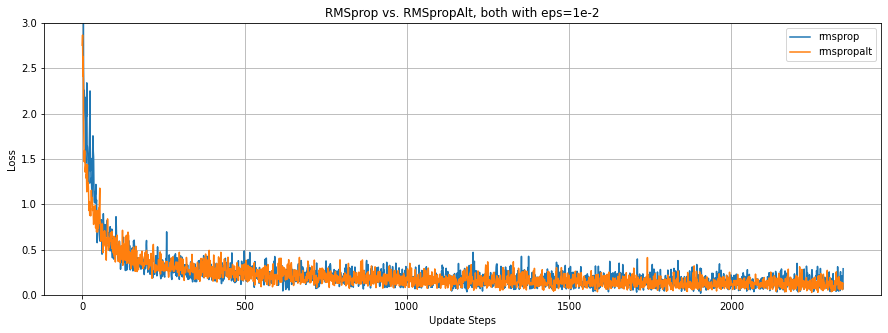

In [78]:
losses = [rmsprop_losses[1e-2], rmspropalt_losses[1e-2]]
labels = ['rmsprop', 'rmspropalt']

plot_losses(losses, labels, 'RMSprop vs. RMSpropAlt, both with eps=1e-2', ymax=3.0)

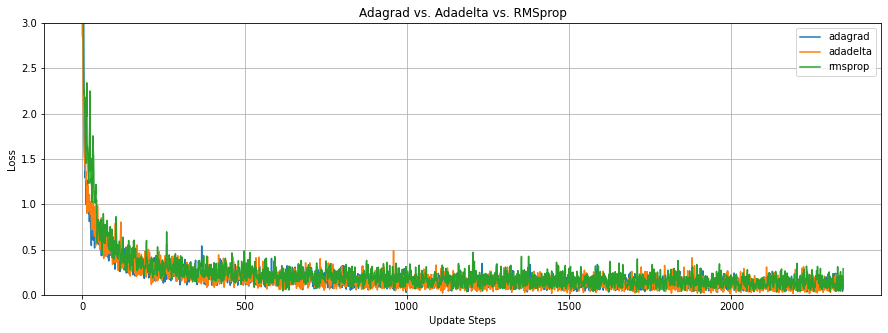

In [79]:
losses = [adagrad_loss, adadelta_loss, rmsprop_losses[1e-2]]
labels = ['adagrad', 'adadelta', 'rmsprop']

plot_losses(losses, labels, 'Adagrad vs. Adadelta vs. RMSprop', ymax=3.0)

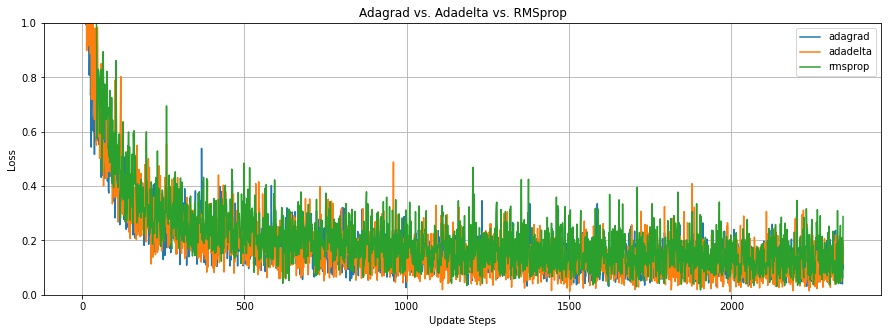

In [80]:
losses = [adagrad_loss, adadelta_loss, rmsprop_losses[1e-2]]
labels = ['adagrad', 'adadelta', 'rmsprop']

plot_losses(losses, labels, 'Adagrad vs. Adadelta vs. RMSprop', ymax=1.0)

## Optimizer 6: Adam

Adam is what happens when we add momentum to RMSprop. It has an exponential moving average of the gradients, like the momentum term that can be added to SGD, and an exponential moving average of squared gradients, like RMSprop and Adadelta.

$$\theta_{t+1} = \theta_t - \eta \cdot \frac{m_{t,i}}{\sqrt{v_{t,i}}+\epsilon}$$

Where:

\begin{align*}
    m_{t,i} &= \beta_1 m_{t-1,i} + (1-\beta_1)g_{t,i} \\
    v_{t,i} &= \beta_2 v_{t-1,i} + (1-\beta_2)g_{t,i}^2
\end{align*}

Adam's $m_{t,i}$ is equal to $v_{t,i}$ from SGD with momentum if it had a $(1-\gamma)$ term. Adam's $v_{t,i} = E[g^2]_{t,i}$ from RMSprop and Adadelta, with $\rho$ replaced by $\beta_2$.

Due to $m$ and $v$ being initialized to zero and $\beta_1$ and $\beta_2$ being initialized close to one this means the $m$ and $v$ values calculated on the first few steps are "biased" towards very small values. This is why we saw a huge loss for the first steps of Adagrad, Adadelta and RMSprop. To solve this, Adam uses "bias corrected" values of $m$ and $v$, calculated as:

\begin{align*}
    \hat{m}_{t,i} &= \frac{m_{t,i}}{1-\beta_1^t} \\
    \hat{v}_{t,i} &= \frac{v_{t,i}}{1-\beta_2^t}
\end{align*}

Where $t$ is the time-step. 

$$\theta_{t+1} = \theta_t - \eta \cdot \frac{\hat{m}_{t,i}}{\sqrt{\hat{v}_{t,i}}+\epsilon}$$

Note that the bias corrected values on the first call to `step` are calculated with $t = 1$ and not $t = 0$.

In [81]:
class Adam:
    def __init__(self, model_params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.beta_1, self.beta_2 = betas
        self.eps = eps
        self.avg_grads = [torch.zeros_like(p) for p in self.model_params]
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        self.n_steps = 0
        
    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_grad, avg_sqr_grad in zip(self.model_params, \
                                                 self.avg_grads, \
                                                 self.avg_sqr_grads):
            
            self.n_steps += 1
            
            avg_grad.mul_(self.beta_1).add_(param.grad * (1 - self.beta_1))
            
            avg_sqr_grad.mul_(self.beta_2).add_(param.grad * param.grad * (1 - self.beta_2))
            
            avg_grad_corrected = avg_grad.div(1 - self.beta_1 ** self.n_steps)
            
            avg_sqr_grad_corrected = avg_sqr_grad.div(1 - self.beta_2 ** self.n_steps)
            
            std = avg_sqr_grad_corrected.sqrt().add(self.eps)
            
            param.sub_(self.lr * avg_grad_corrected / std)

In [82]:
optimizer = Adam(model.parameters())

In [83]:
adam_loss = train(train_iterator, model, optimizer, criterion, device)

 33%|███▎      | 156/469 [00:03<00:06, 49.28it/s]


KeyboardInterrupt: 

In [ ]:
plot_loss(adam_loss, 'Adam with lr=1e-3, betas=(0.9, 0.999), eps=1e-8')

In [ ]:
losses = [adagrad_loss, adadelta_loss, rmsprop_losses[1e-2], adam_loss]
labels = ['adagrad', 'adadelta', 'rmsprop', 'adam']

plot_losses(losses, labels, 'Adagrad vs. Adadelta vs. RMSprop vs. Adam', ymax=3.0)

In [ ]:
losses = [adagrad_loss, adadelta_loss, rmsprop_losses[1e-2], adam_loss]
labels = ['adagrad', 'adadelta', 'rmsprop', 'adam']

plot_losses(losses, labels, 'Adagrad vs. Adadelta vs. RMSprop vs. Adam', ymax=0.5)

In [ ]:
def moving_average(x, w=5):
    return np.convolve(x, np.ones(w), 'valid') / w

In [ ]:
losses = [adagrad_loss, adadelta_loss, rmsprop_losses[1e-2], adam_loss]
smoothed_losses = [moving_average(loss) for loss in losses]
labels = ['adagrad', 'adadelta', 'rmsprop', 'adam']

plot_losses(smoothed_losses, labels, 'Adagrad vs. Adadelta vs. RMSprop vs. Adam', ymax=0.5)